![Image of Yaktocat](https://oepfelbaum.com/wp_live/wp-content/themes/appletree/dist/img/logo-main_ed18093c87353e6715bcc40c699c37f9.png)

# Oe LuKB Market Risk - Jupyter Notebook

**Author**: Fabian Arter <br>
**Date**: 2022-01-29 - 2022-05-01

The aim of this notebook is the explain the main concepts of market risk.

## Volatility & Return Distribution

### Set Input Data


<div class="alert alert-block alert-info">
<b>Input:</b> Please choose here for which titles you would like to see historical data. 
</div>



   Check **Yahoo Finance** for all tickers: [https://finance.yahoo.com](https://finance.yahoo.com/lookup) 

Enter in the below `data.frame` the desired tickers (incl. a friendly name, which can be chosen by you)

In [1]:
input.tickers.df = data.frame(ticker=c("ROG.SW", 
                                       "NESN.SW", 
                                       "NOVN.SW", 
                                       "^SSMI"),
                               friendly.name=c("Roche", 
                                               "Nestle", 
                                               "Novartis", 
                                               "SMI")
                              )


<div class="alert alert-block alert-info">
<b>Input:</b> Please choose here the start and end date of the historical price data. 
</div>



In [2]:
start.date = as.Date("2010-01-01")
last.date  = Sys.Date() # today 

In [3]:
print(input.tickers.df)
message(paste("start date:",start.date))
message(paste("last date: ",last.date))

   ticker friendly.name
1  ROG.SW         Roche
2 NESN.SW        Nestle
3 NOVN.SW      Novartis
4   ^SSMI           SMI


start date: 2010-01-01
last date:  2022-05-08


### Installing and loading R packages

In [4]:
install.packages("ggplot2")
install.packages("BatchGetSymbols")
install.packages("dplyr")




#install.packages("reshape2")
library(ggplot2)
library(BatchGetSymbols)
library(dplyr)



Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: rvest
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Loading Historical End of Day Data from Yahoo Finance

In [5]:


#' etlFinData
#'
#' @param start.date Start Date of the historical price data
#' @param end.date  End Date of the historical price data
#' @param input.tickers.df Data Frame with the products we wish to have the prices, this includes the ticker symbol and a friendly name
#' @return a list with two data frames: cumulated.returns.data.long and cumulated.returns.data.long
#' @export
etlFinData <- function(start.date=as.Date("2018-01-01"), 
                       last.date =Sys.Date(),
                       input.tickers.df = data.frame(ticker=c("LUKN.SW","AIR.PA"),
                                                     friendly.name=c("LUKN.SW","AIRBUS"))
) {
  
  # load data via BatchGetSymbols
  daily.returns.data.long <- suppressWarnings(BatchGetSymbols::BatchGetSymbols(
    tickers      = as.character(input.tickers.df$ticker),
    first.date   = start.date,
    last.date    = last.date,
    freq.data    = "daily",
    type.return  = "log",
    cache.folder = file.path(tempdir(), 'BGS_Cache') )$df.tickers)
  
  
  # add friendly names
  daily.returns.data.long <-  merge(daily.returns.data.long, input.tickers.df, by="ticker")
  
  daily.returns.data.long[is.na(daily.returns.data.long$ret.adjusted.prices),]$ret.adjusted.prices <- 0
  daily.returns.data.long <- na.omit(daily.returns.data.long)
  
  daily.returns.data.long <- data.frame(ref.date        = daily.returns.data.long$ref.date,
                                        friendly.name   = as.character(daily.returns.data.long$friendly.name),
                                        price.adjusted  = daily.returns.data.long$price.adjusted,
                                        daily.return    = daily.returns.data.long$ret.adjusted.prices)
  
  daily.returns.data.wide <- reshape2::dcast(daily.returns.data.long,  ref.date ~ friendly.name, value.var = "daily.return")
  daily.returns.data.wide <- na.omit(daily.returns.data.wide)
  
  # cumulated returns wide
  cumulated.returns.data.wide  <- if(nrow(input.tickers.df) !=1) {
    as.data.frame(cbind(ref.date = daily.returns.data.wide$ref.date, apply(daily.returns.data.wide[,2:ncol(daily.returns.data.wide)], 2, cumsum)))
    
  }
    

  # cumulated returns long
  cumulated.returns.data.long <- if(nrow(input.tickers.df) !=1) {
    cumulated.returns.data.long               <- reshape2::melt(cumulated.returns.data.wide, id.vars=1, measure.vars = 2:ncol(cumulated.returns.data.wide))
    cumulated.returns.data.long$ref.date      <- as.Date(cumulated.returns.data.long$ref.date, origin = "1970-01-01")
    cumulated.returns.data.long$name          <- as.character(cumulated.returns.data.long$variable) ; cumulated.returns.data.long$variable <- NULL
    cumulated.returns.data.long$cumul.return  <- cumulated.returns.data.long$value ; cumulated.returns.data.long$value <- NULL
    cumulated.returns.data.long
  } else {
    data.frame(ref.date = daily.returns.data.long$ref.date, name = daily.returns.data.long$friendly.name, cumul.return=cumsum(daily.returns.data.long$daily.return))
  }
  
  cumulated.returns.data.wide$ref.date      <- as.Date(as.numeric(cumulated.returns.data.wide$ref.date), origin = "1970-01-01")
  
  return(list(daily.returns.data.long     = daily.returns.data.long,
              daily.returns.data.wide     = daily.returns.data.wide,
              cumulated.returns.data.long = cumulated.returns.data.long,
              cumulated.returns.data.wide = cumulated.returns.data.wide))
  
}    

In [6]:
PF.daily.return <- etlFinData(start.date = start.date,
                               last.date = last.date,
                              input.tickers.df = input.tickers.df)

PF.daily.return.wide <- PF.daily.return$daily.returns.data.wide
PF.daily.return.long <- PF.daily.return$daily.returns.data.long
PF.daily.cumul.long  <- PF.daily.return$cumulated.returns.data.long 




Running BatchGetSymbols for:
   tickers =ROG.SW, NESN.SW, NOVN.SW, ^SSMI
^GSPC | yahoo (1|1) | Not Cached | Saving cache
ROG.SW | yahoo (1|4) | Not Cached | Saving cache - Got 97.5% of valid prices | Well done!
NESN.SW | yahoo (2|4) | Not Cached | Saving cache - Got 97.5% of valid prices | Got it!
NOVN.SW | yahoo (3|4) | Not Cached | Saving cache - Got 97.5% of valid prices | Well done!
^SSMI | yahoo (4|4) | Not Cached | Saving cache - Got 97.2% of valid prices | You got it!

### Historical Returns Normalized

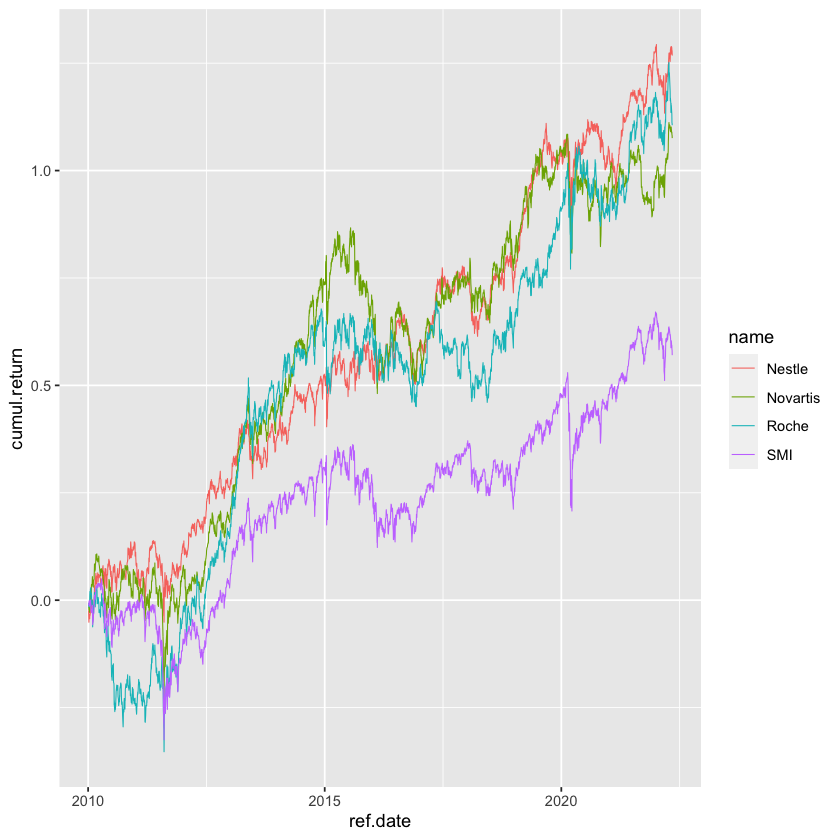

In [7]:
# Cumulated return plot
ggplot(PF.daily.cumul.long, aes(y=cumul.return, x=ref.date, color=name)) + geom_line(size=0.3)  

### Daily Returns

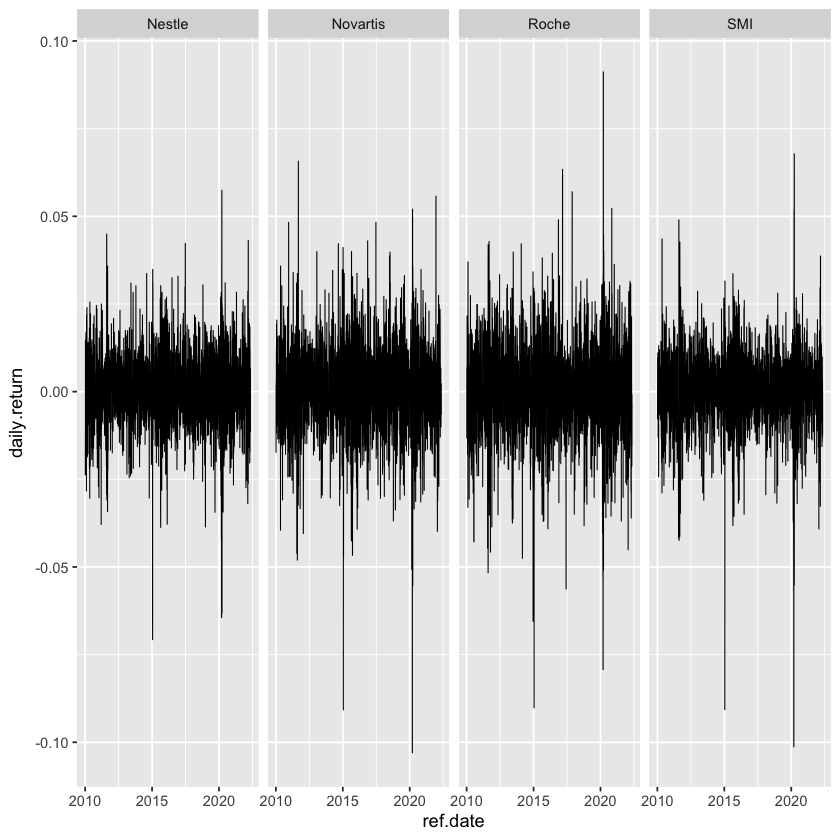

In [8]:
# return plot
ggplot(PF.daily.return.long, aes(y=daily.return, x=ref.date)) + geom_line(size=0.3)  + facet_grid(~ friendly.name)
 

### Histogram of Daily Returns

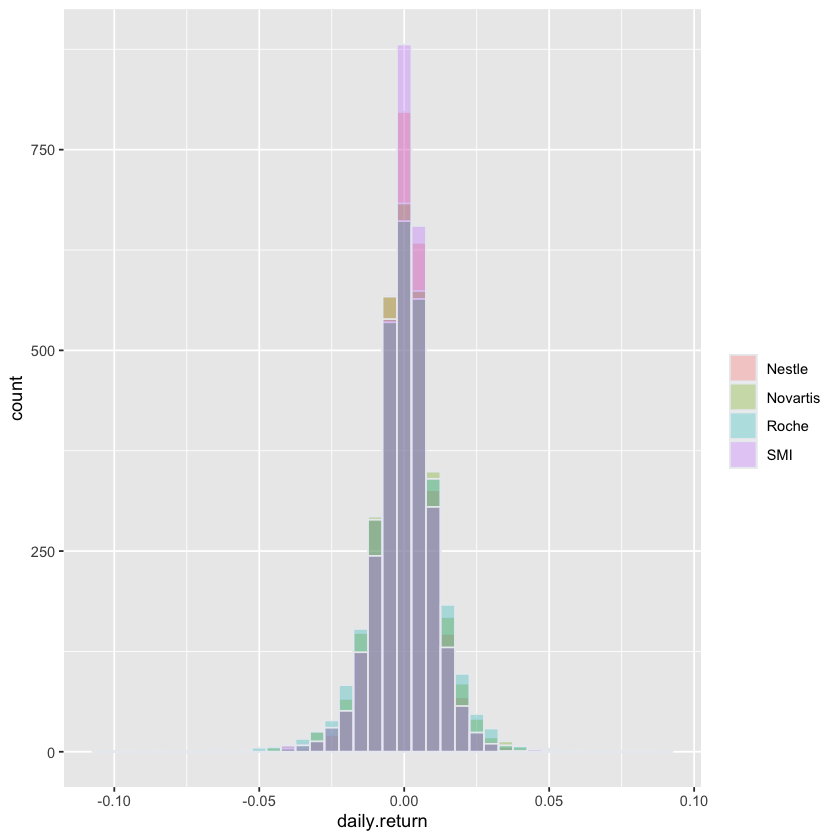

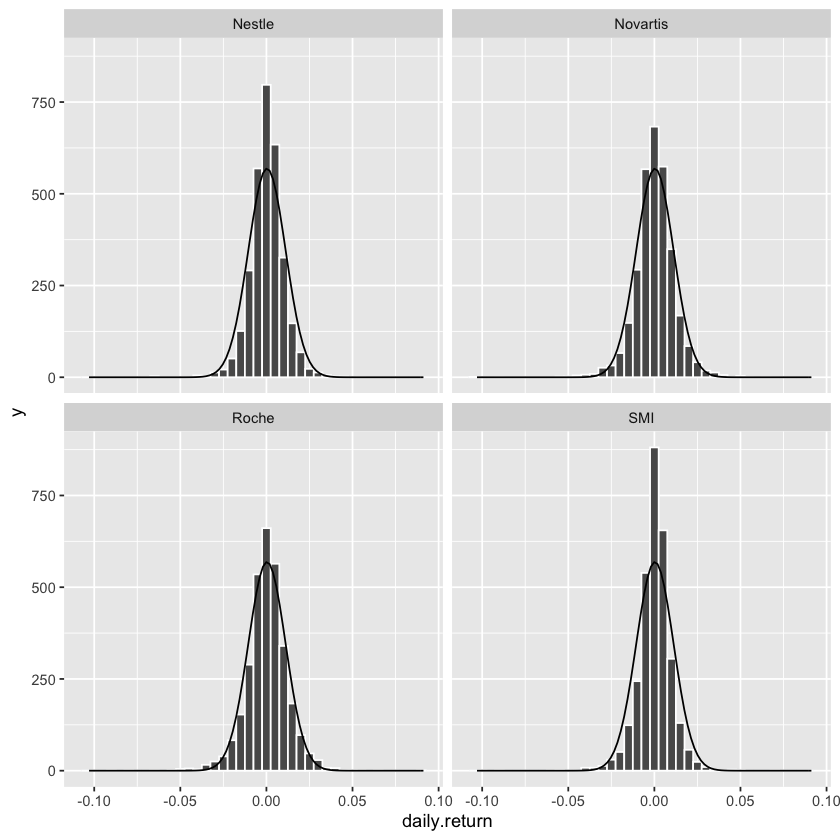

In [9]:
binwidth.set = 0.005
stocks.count = nrow(input.tickers.df)

ggplot(PF.daily.return.long, aes(x=daily.return, fill=friendly.name,binwidth = binwidth.set)) +
    geom_histogram( color="#e9ecef", alpha=0.3, position = 'identity',binwidth = binwidth.set) +
    labs(fill="")

ggplot(PF.daily.return.long, aes(x=daily.return, binwidth = binwidth.set)) +
    geom_histogram( color="#e9ecef", alpha=0.3, position = 'identity',binwidth = binwidth.set) +
    labs(fill="") + facet_wrap(~friendly.name) + 
    geom_histogram(colour = "white", binwidth = binwidth.set) +
stat_function(fun = function(x) dnorm(x, mean = mean(PF.daily.return.long$daily.return), sd = sd(PF.daily.return.long$daily.return)) * nrow(PF.daily.return.long)/stocks.count * binwidth.set) 

### Statistics: Daily Retun Percentiles & Check for Normality
**Shapiro-Wilk Test for Normality** 
Null hypothesis: The data is normally distributed. If p> 0.05, normality can be assumed

In [10]:
 
PF.daily.return.long %>% group_by(friendly.name) %>% 
  summarise(min = min(daily.return)
            ,max = max(daily.return)
            ,mean = mean(daily.return)
            ,sd = sd(daily.return)
            ,n = n()
            ,q05 = quantile(daily.return, .05)
            ,q01 = quantile(daily.return, .01)
            ,q95 = quantile(daily.return, .95)
            ,q99 = quantile(daily.return, .99)
            ,shapiro.normality.pvalue = as.numeric(shapiro.test(daily.return)[2])
            ) 



friendly.name,min,max,mean,sd,n,q05,q01,q95,q99,shapiro.normality.pvalue
Nestle,-0.07074042,0.05742957,0.0004092408,0.009718699,3103,-0.01485212,-0.02544738,0.01591060,0.02501239,4.570638e-28
Novartis,-0.10299928,0.06573293,0.0003469270,0.011507636,3103,-0.01739910,-0.03105377,0.01858667,0.03018859,1.408447e-30
Roche,-0.09018420,0.09119587,0.0003512901,0.012184488,3103,-0.01888478,-0.03524051,0.01940388,0.03077397,5.825773e-29
SMI,-0.10133930,0.06780465,0.0001844643,0.009873741,3092,-0.01544125,-0.02885311,0.01446864,0.02422355,1.228375e-36


### QQ Plots

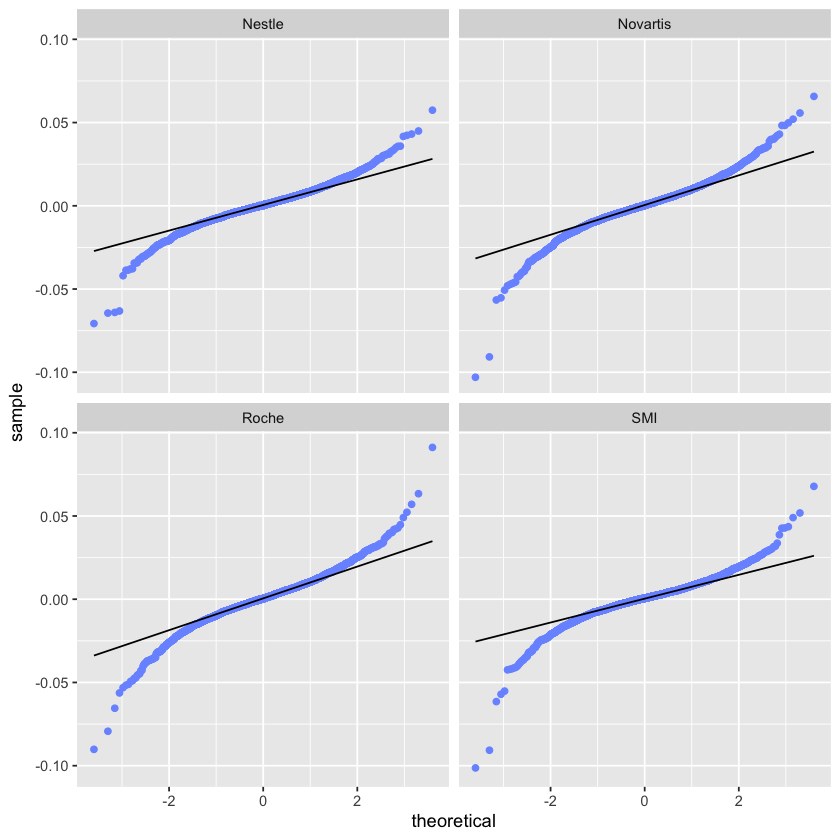

In [11]:
ggplot(PF.daily.return.long) +
    stat_qq(aes(sample=daily.return),colour = "#7997FF") + 
    stat_qq_line(aes(sample = daily.return)) + xlab("theoretical") + ylab("sample") +
   facet_wrap(~friendly.name)  

## Volatility

### Unweighted Historical Volatility

In [12]:

rollingVola <- function(PF.daily.return.long, n.days) {
  
  n.days.total <- nrow(PF.daily.return.long)
  n.rows       <- n.days.total-n.days
  
  rolling.vola.data <- data.frame(ref.date      = rep(as.Date(NA),length=n.rows),
                                  friendly.name = rep(NA,length=n.rows),
                                  vola.estim    = rep(NA,length=n.rows),
                                  vola.method   = "simple - rolling",
                                  n.days.vola   = n.days)
                                  
  for (j in 1:n.rows) {
  #  print(j)
  #  print(paste(PF.daily.return.long$ref.date[j],"-",PF.daily.return.long$ref.date[n.days+j]))
    rolling.vola.data$friendly.name[j]   <- as.character(PF.daily.return.long$friendly.name[(n.days+j)])
    rolling.vola.data$ref.date[j]   <- PF.daily.return.long$ref.date[(n.days+j)]
    rolling.vola.data$vola.estim[j] <- (sd(PF.daily.return.long$daily.return[j:(n.days+j)]))
  }
  return(rolling.vola.data)
}

rollingSDandCorrel <- function(PF.daily.return.long, n.days=c(60,120,250,500)) {
  
tickers <- unique(PF.daily.return.long$friendly.name)

input.table <- data.frame(ticker=rep(tickers,each=length(n.days)), n.days = n.days)
print(input.table)
# Rolling Vola for each ticker
rolling.vola.list <- vector("list", length= nrow(input.table))

  
  for(i in 1:nrow(input.table)) {
    PF.daily.return.single <- PF.daily.return.long[PF.daily.return.long$friendly.name==input.table$ticker[i],]
    PF.daily.return.single$friendly.name == as.character(PF.daily.return.single$friendly.name) 
    input.table$n.days[i] <- ifelse(nrow(PF.daily.return.single)<input.table$n.days[i],nrow(PF.daily.return.single)-2,input.table$n.days[i])
    print(head(PF.daily.return.single))


    rolling.vola.list[[i]] <-  rollingVola(PF.daily.return.single, n.days=input.table$n.days[i])
    print(paste(i, "...",input.table[i,]))  
  }
  
  rolling.vola.data.long <- plyr::rbind.fill(rolling.vola.list)
  
  return(rolling.vola.data.long)
  
}


In [13]:

rolling.vola.data.long <- rollingSDandCorrel(PF.daily.return.long, n.days=c(60,120,250,500))



     ticker n.days
1    Nestle     60
2    Nestle    120
3    Nestle    250
4    Nestle    500
5  Novartis     60
6  Novartis    120
7  Novartis    250
8  Novartis    500
9     Roche     60
10    Roche    120
11    Roche    250
12    Roche    500
13      SMI     60
14      SMI    120
15      SMI    250
16      SMI    500
    ref.date friendly.name price.adjusted  daily.return
1 2010-01-05        Nestle       33.83170 -0.0238342650
2 2010-01-06        Nestle       33.29447 -0.0160070644
3 2010-01-07        Nestle       32.91365 -0.0115036702
4 2010-01-08        Nestle       33.39648  0.0145630381
5 2010-01-11        Nestle       33.20607 -0.0057178140
6 2010-01-12        Nestle       33.18567 -0.0006146849
[1] "1 ... 1"  "1 ... 60"
    ref.date friendly.name price.adjusted  daily.return
1 2010-01-05        Nestle       33.83170 -0.0238342650
2 2010-01-06        Nestle       33.29447 -0.0160070644
3 2010-01-07        Nestle       32.91365 -0.0115036702
4 2010-01-08        Nestle       33

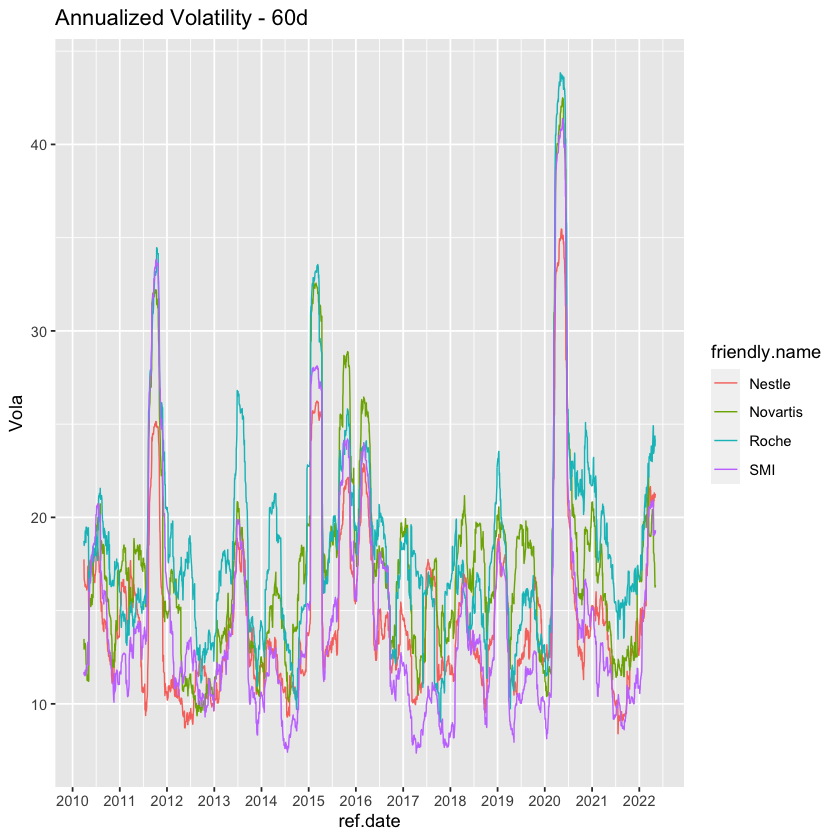

In [14]:

ggplot(rolling.vola.data.long[rolling.vola.data.long$n.days.vola==60,], aes(y=vola.estim*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility - 60d") + 
scale_x_date(date_breaks = "1 year", date_labels = "%Y")

 

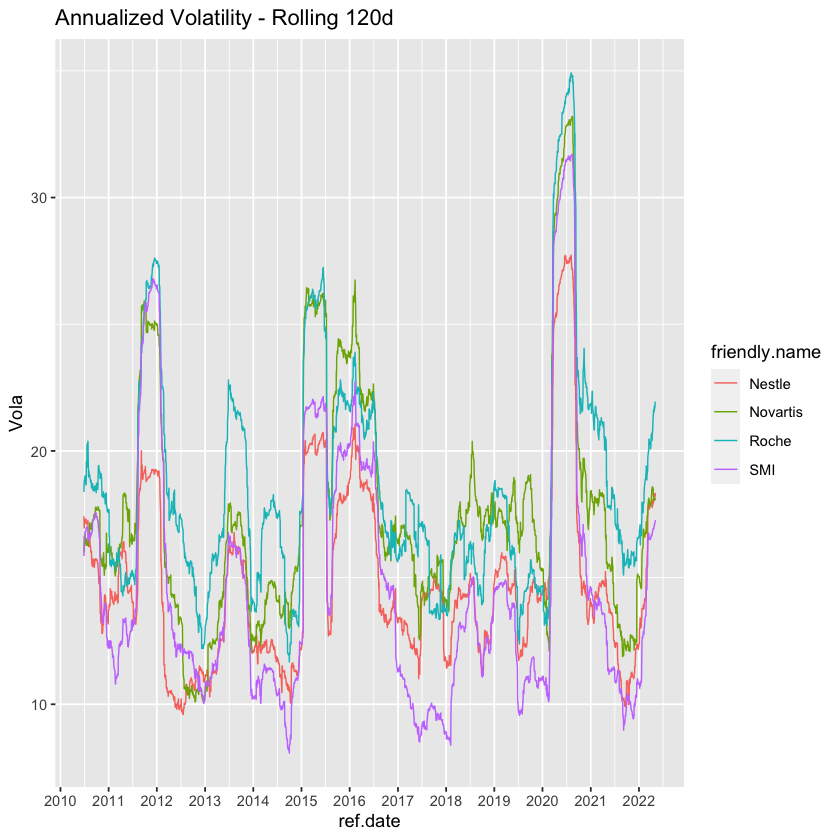

In [15]:
ggplot(rolling.vola.data.long[rolling.vola.data.long$n.days.vola==120,], aes(y=vola.estim*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility - Rolling 120d") + 
scale_x_date(date_breaks = "1 year", date_labels = "%Y")




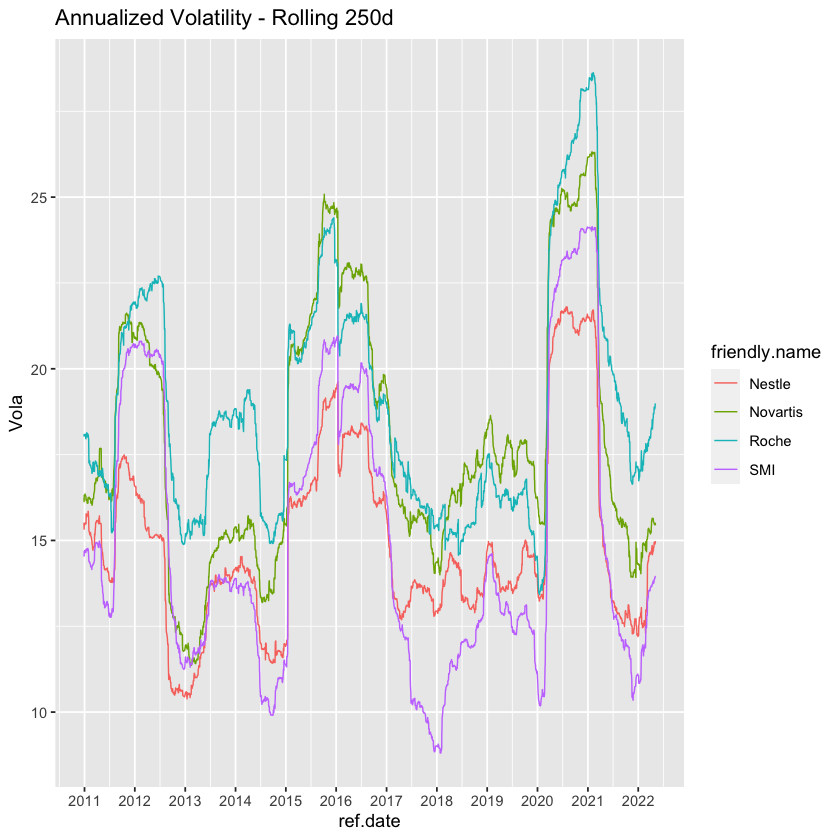

In [16]:
ggplot(rolling.vola.data.long[rolling.vola.data.long$n.days.vola==250,], aes(y=vola.estim*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility - Rolling 250d") + 
scale_x_date(date_breaks = "1 year", date_labels = "%Y")




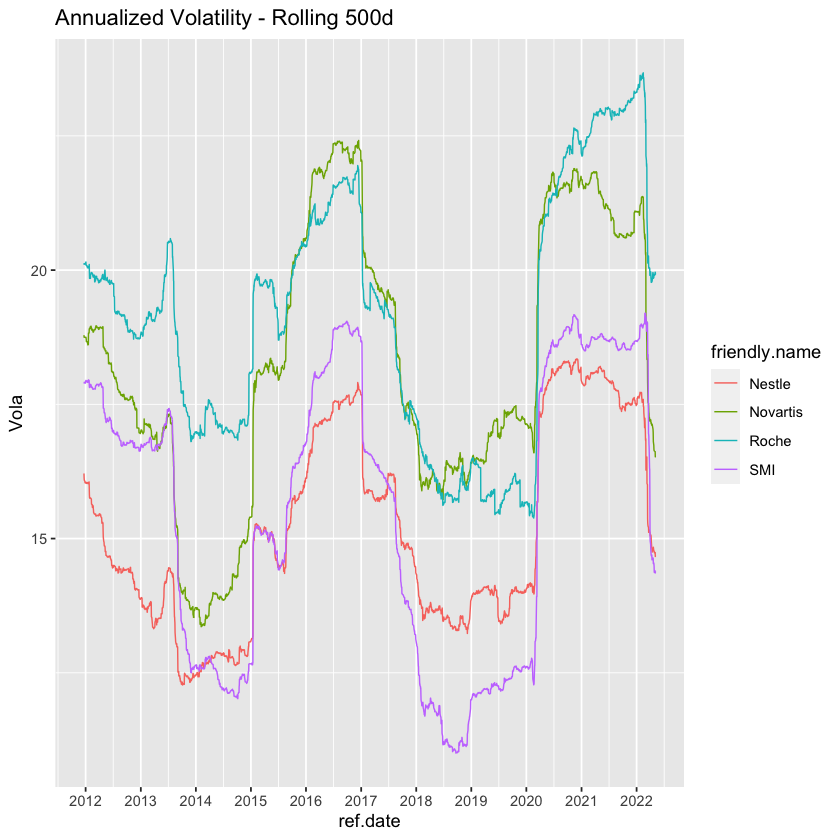

In [17]:
ggplot(rolling.vola.data.long[rolling.vola.data.long$n.days.vola==500,], aes(y=vola.estim*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility - Rolling 500d") + 
scale_x_date(date_breaks = "1 year", date_labels = "%Y")



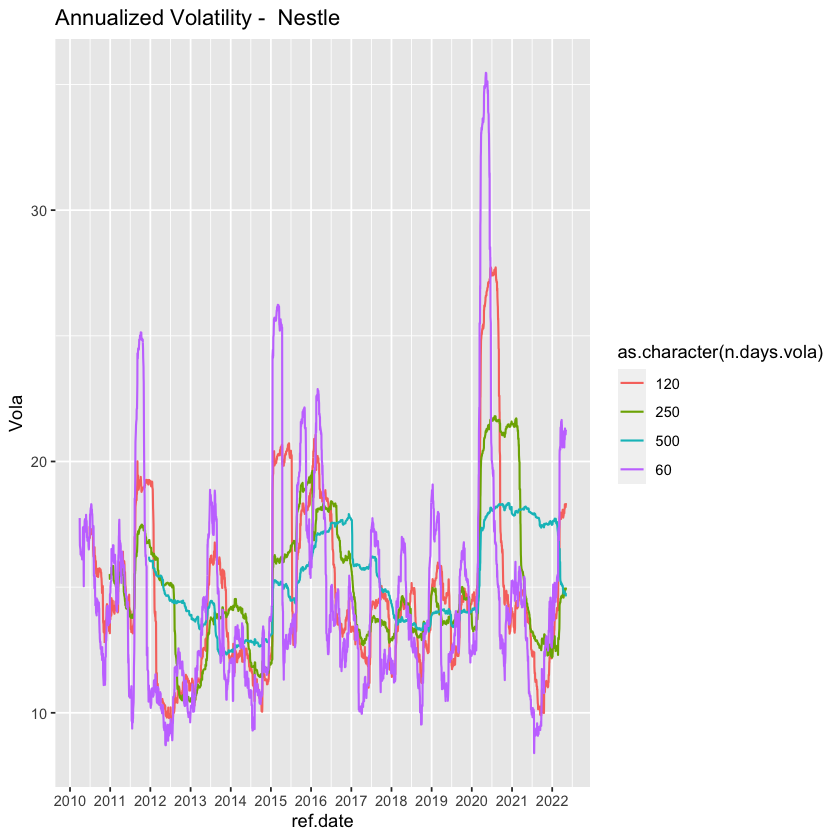

In [23]:
ggplot(rolling.vola.data.long[rolling.vola.data.long$friendly.name==rolling.vola.data.long$friendly.name[1],], aes(y=vola.estim*sqrt(250)*100, x=ref.date, colour=as.character(n.days.vola))) + 
geom_line(size=0.6 ) + ylab("Vola") + ggtitle(paste("Annualized Volatility - ",rolling.vola.data.long$friendly.name[1])) + 
scale_x_date(date_breaks = "1 year", date_labels = "%Y")



## Correlation

In [ ]:
library(zoo)

SMI <- PF.daily.return.wide %>%select(ref.date, SMI)
Nestle <- PF.daily.return.wide %>%select(ref.date, Nestle)
Nestle$ref.date <-NULL
SMI_Nestle = cbind(SMI, Nestle)
SMI_Nestle$RollingCorr60 <- c( c(rep(NA, 59)), rollapply(SMI_Nestle[-1], 60, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Nestle$RollingCorr120 <- c( c(rep(NA, 119)), rollapply(SMI_Nestle[-1], 120, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Nestle$RollingCorr250 <- c( c(rep(NA, 249)), rollapply(SMI_Nestle[-1], 250, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Nestle$RollingCorr500 <- c( c(rep(NA, 499)), rollapply(SMI_Nestle[-1], 500, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Nestle$RollingCorr750 <- c( c(rep(NA, 749)), rollapply(SMI_Nestle[-1], 750, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Nestle$Nestle <- NULL
SMI_Nestle$SMI <- NULL                                
SMI_Nestle <- reshape2::melt(SMI_Nestle, id.vars=1, measure.vars = 2:5)                                                         
ggplot(SMI_Nestle, aes(y=value, x=ref.date, color=variable)) + geom_line(size=0.3) + ggtitle("SMI-Nestle")
                                                           
SMI <- PF.daily.return.wide %>%select(ref.date, SMI)
Novartis <- PF.daily.return.wide %>%select(ref.date, Novartis)
Novartis$ref.date <-NULL
SMI_Novartis = cbind(SMI, Novartis)
SMI_Novartis$RollingCorr60 <- c( c(rep(NA, 59)), rollapply(SMI_Novartis[-1], 60, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Novartis$RollingCorr120 <- c( c(rep(NA, 119)), rollapply(SMI_Novartis[-1], 120, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Novartis$RollingCorr250 <- c( c(rep(NA, 249)), rollapply(SMI_Novartis[-1], 250, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Novartis$RollingCorr500 <- c( c(rep(NA, 499)), rollapply(SMI_Novartis[-1], 500, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Novartis$RollingCorr750 <- c( c(rep(NA, 749)), rollapply(SMI_Novartis[-1], 750, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Novartis$Novartis <- NULL
SMI_Novartis$SMI <- NULL                                
SMI_Novartis <- reshape2::melt(SMI_Novartis, id.vars=1, measure.vars = 2:5)                                                         
ggplot(SMI_Novartis, aes(y=value, x=ref.date, color=variable)) + geom_line(size=0.3) + ggtitle("SMI-Novartis") 
                                                             
SMI <- PF.daily.return.wide %>%select(ref.date, SMI)
Roche <- PF.daily.return.wide %>%select(ref.date, Roche)
Roche$ref.date <-NULL
SMI_Roche = cbind(SMI, Roche)
SMI_Roche$RollingCorr60 <- c( c(rep(NA, 59)), rollapply(SMI_Roche[-1], 60, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Roche$RollingCorr120 <- c( c(rep(NA, 119)), rollapply(SMI_Roche[-1], 120, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Roche$RollingCorr250 <- c( c(rep(NA, 249)), rollapply(SMI_Roche[-1], 250, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Roche$RollingCorr500 <- c( c(rep(NA, 499)), rollapply(SMI_Roche[-1], 500, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Roche$RollingCorr750 <- c( c(rep(NA, 749)), rollapply(SMI_Roche[-1], 750, function(x) cor(x[,1],x[,2]), by.column=FALSE))
SMI_Roche$Roche <- NULL
SMI_Roche$SMI <- NULL                                
SMI_Roche <- reshape2::melt(SMI_Roche, id.vars=1, measure.vars = 2:5)                                                         
ggplot(SMI_Roche, aes(y=value, x=ref.date, color=variable)) + geom_line(size=0.3) + ggtitle("SMI-Roche")
                                                          
                                                          Novartis <- PF.daily.return.wide %>%select(ref.date, Novartis)
Roche <- PF.daily.return.wide %>%select(ref.date, Roche)
Roche$ref.date <-NULL
Novartis_Roche = cbind(Novartis, Roche)
Novartis_Roche$RollingCorr60 <- c( c(rep(NA, 59)), rollapply(Novartis_Roche[-1], 60, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Roche$RollingCorr120 <- c( c(rep(NA, 119)), rollapply(Novartis_Roche[-1], 120, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Roche$RollingCorr250 <- c( c(rep(NA, 249)), rollapply(Novartis_Roche[-1], 250, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Roche$RollingCorr500 <- c( c(rep(NA, 499)), rollapply(Novartis_Roche[-1], 500, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Roche$RollingCorr750 <- c( c(rep(NA, 749)), rollapply(Novartis_Roche[-1], 750, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Roche$Roche <- NULL
Novartis_Roche$Novartis <- NULL                                
Novartis_Roche <- reshape2::melt(Novartis_Roche, id.vars=1, measure.vars = 2:5)                                                         
ggplot(Novartis_Roche, aes(y=value, x=ref.date, color=variable)) + geom_line(size=0.3) + ggtitle("Novartis-Roche")
                                                               
Novartis <- PF.daily.return.wide %>%select(ref.date, Novartis)
Nestle <- PF.daily.return.wide %>%select(ref.date, Nestle)
Nestle$ref.date <-NULL
Novartis_Nestle = cbind(Novartis, Nestle)
Novartis_Nestle$RollingCorr60 <- c( c(rep(NA, 59)), rollapply(Novartis_Nestle[-1], 60, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Nestle$RollingCorr120 <- c( c(rep(NA, 119)), rollapply(Novartis_Nestle[-1], 120, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Nestle$RollingCorr250 <- c( c(rep(NA, 249)), rollapply(Novartis_Nestle[-1], 250, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Nestle$RollingCorr500 <- c( c(rep(NA, 499)), rollapply(Novartis_Nestle[-1], 500, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Nestle$RollingCorr750 <- c( c(rep(NA, 749)), rollapply(Novartis_Nestle[-1], 750, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Novartis_Nestle$Nestle <- NULL
Novartis_Nestle$Novartis <- NULL                                
Novartis_Nestle <- reshape2::melt(Novartis_Nestle, id.vars=1, measure.vars = 2:5)                                                         
ggplot(Novartis_Nestle, aes(y=value, x=ref.date, color=variable)) + geom_line(size=0.3) + ggtitle("Novartis-Nestle") 
                                                                
Roche <- PF.daily.return.wide %>%select(ref.date, Roche)
Nestle <- PF.daily.return.wide %>%select(ref.date, Nestle)
Nestle$ref.date <-NULL
Roche_Nestle = cbind(Roche, Nestle)
Roche_Nestle$RollingCorr60 <- c( c(rep(NA, 59)), rollapply(Roche_Nestle[-1], 60, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Roche_Nestle$RollingCorr120 <- c( c(rep(NA, 119)), rollapply(Roche_Nestle[-1], 120, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Roche_Nestle$RollingCorr250 <- c( c(rep(NA, 249)), rollapply(Roche_Nestle[-1], 250, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Roche_Nestle$RollingCorr500 <- c( c(rep(NA, 499)), rollapply(Roche_Nestle[-1], 500, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Roche_Nestle$RollingCorr750 <- c( c(rep(NA, 749)), rollapply(Roche_Nestle[-1], 750, function(x) cor(x[,1],x[,2]), by.column=FALSE))
Roche_Nestle$Nestle <- NULL
Roche_Nestle$Roche <- NULL                                
Roche_Nestle <- reshape2::melt(Roche_Nestle, id.vars=1, measure.vars = 2:5)                                                         
ggplot(Roche_Nestle, aes(y=value, x=ref.date, color=variable)) + geom_line(size=0.3) + ggtitle("Roche-Nestle")                                                                
                                                         

### Covariance: Code Examples

In [ ]:
install.packages("ggcorrplot")
library(ggcorrplot)

PF.daily.return.data <- etlFinData(start.date=as.Date("2021-01-01"),
                                input.tickers.df = data.frame(ticker=c("^IXIC","AAPL","FB","INTC","MSFT","ABNB","ADBE","AMZN","EA"),
                                                              friendly.name=c("Nasdaq","Apple","Facebook","Intel","Microsoft","AirBnB","Adobe","Amazon","EA"))) 
  
  PF.daily.return.data.wide <- PF.daily.return.data$daily.returns.data.wide
  
  PF.correl.matrix <- cor(PF.daily.return.data.wide[,2:ncol(PF.daily.return.data.wide)])
  library(ggcorrplot)
  
  ggcorrplot(
    PF.correl.matrix,
    hc.order = TRUE,
    #type = "lower",
    outline.color = "white",
    ggtheme = ggplot2::theme_gray,
    colors = c("#6D9EC1", "white", "#E46726"),
    lab = TRUE
  )

# Note that the slope of a linear regression is not the same as the correlation coefficient (!)
  ggplot(PF.daily.return.data.wide, aes(x=Nasdaq, y=Microsoft)) + geom_point() +
    geom_smooth(method=lm, se=FALSE)
 
# Correlation example Microsoft, Nasdaq
  correl.manual = cov(PF.daily.return.data.wide$Microsoft, PF.daily.return.data.wide$Nasdaq) / (sd(PF.daily.return.data.wide$Microsoft)*sd(PF.daily.return.data.wide$Nasdaq))
  print(correl.manual)

## Value at Risk ##
As defined by Wilmott (2007) <em>Value at Risk (VaR)</em> 
"is an estimate, with a given degree of confidence, of how much on can lose from one's portfolio over a given time horizon"

### Value at Risk: Code Examples

#### Value at Risk: Functions

In [ ]:

# VaR Functions

#' @param daily.volatility The applied volatility for the shift
#' @param VaR.confidence Confidence level of the Value at Risk (VaR) shift
#' @param VaR.period.days Holding period in days for the VaR shift
#' @return a shifted price according to volatility, VaR confidence level and VaR period
#' @name VaRparamSingle
#' @examples
#' VaR(price=100, position=1, daily.volatility=0.01, VaR.confidence=0.99, VaR.period.days=5)
#' @export
VaRparamSingle <- function(daily.volatility, VaR.confidence=0.99, VaR.period.days=5) {
  param.var.single = -daily.volatility*qnorm(VaR.confidence)*sqrt(VaR.period.days)
  return(param.var.single)
}


#' @title VaRparamPortfolio
#' @description This function returns the Value at Risk of a Portfolio
#' @param vector with individual.var
#' @param correlation.matrix
#' @return a Portfolio VaR
#' @name VaRparamPortfolio
#' @export
VaRparamPortfolio <- function(individual.var.vector, correlation.matrix) {

  portfolio.var <- sqrt(individual.var.vector  %*% correlation.matrix  %*% individual.var.vector)
  return(portfolio.var)
}


#' @param VaR.confidence Confidence level of the Value at Risk (VaR) shift
#' @param historical.return.ts - Historical returns timeseries of single stock
#' @param price Original price (pre-shift) per unit
#' @param position size of the position

VaRHistSimSingle <- function(historical.return.ts, VaR.confidence) {

hs.var.single <- as.numeric(quantile(historical.return.ts,1-VaR.confidence))                       
return(hs.var.single)
}    

#' @param daily.returns.ts - Historical returns timeseries of single stock  
#' @param VaR.confidence Confidence level of the Value at Risk (VaR) shift
#' @param lambda - time decay factor
  VaRHistSimWeightSingle <- function(daily.returns.ts, lambda, VaR.confidence) {
    
    K = length(daily.returns.ts)
    hist.return.data <- data.frame(return=daily.returns.ts, days.ago.n=c(1:K))
    hist.return.data$time.weight <- (1-lambda)*lambda^(hist.return.data$days.ago.n-1)/(1-lambda^K)
    hist.return.data2 <- hist.return.data[order(hist.return.data$return),]
    hist.return.data2$weight.cumul <- cumsum(hist.return.data2$time.weight)
    var.hist.time.weighted <- approx(x=hist.return.data2$weight.cumul, y=hist.return.data2$return, xout=1-VaR.confidence)$y
    return(var.hist.time.weighted)
  }   
   


EWMAvolaEstim <- function(daily.returns.ts,lambda=0.94,time.period=100) {
    
    ewma.vector <- (1-lambda)*lambda^(c(1:time.period)-1)/(1-lambda^time.period)
    estimation.vola.yesterday <- sqrt(sum(daily.returns.ts[2:(time.period+1)]^2*ewma.vector))
    estimation.return2        <- daily.returns.ts[2]^2
    
    estimation.vola.today <- sqrt(lambda*estimation.vola.yesterday^2 + (1-lambda)*estimation.return2)
    return(estimation.vola.today)
  }



# Conditional VaR / Expected Shortfall Using Historical Returns
# description calculates the historical Conditional VaR / Expected Shortfall of a portfolio or an asset
# param daily.returns Daily historical returns of a portfolio or single asset
# param alpha.cvar Alpha of the CVaR, this is the confidence level from which on the average of the tail risk is being calculated
# return cvar CVaR of the specific portfolio or asset with the set alpha
histCVaRcalc <- function(asset.weights=1, daily.returns.data.wide, alpha.cvar) {
  i.num = ceiling(alpha.cvar * nrow(daily.returns.data.wide))
  portfolio.returns <- as.matrix(daily.returns.data.wide[,2:length(daily.returns.data.wide)]) %*% c(asset.weights)
  portfolio.returns <- sort(portfolio.returns)
  cvar = mean(portfolio.returns[1:i.num])
  return(cvar)
}


#### Code Examples - Execution

In [ ]:
# VaR (1 title) - LuKB

# 1d VaR, 99% confidence

historical.return.ts <- PF.daily.return.wide$LUKN.SW
VaR.confidence  = 0.99 # confidence level
VaR.period.days = 1    # holding period
time.period     = 100  # num historical days 
lambda          = 0.94 # time decay factor


# Example - Parametric VaR 
param.var.single <- VaRparamSingle(
                                daily.volatility=sd(historical.return.ts[1:time.period]),
                                VaR.confidence=VaR.confidence,
                                VaR.period.days=VaR.period.days)

# Example - Hist Single VaR 
hs.var.single <- VaRHistSimSingle(historical.return.ts[1:time.period], VaR.confidence)

# Example - Hist Weight Single VaR 
hs.weight.var.single <- VaRHistSimWeightSingle(historical.return.ts[1:time.period], lambda, VaR.confidence)


# Example - EWMA
ewma.vola <- EWMAvolaEstim(historical.return.ts,lambda,time.period)
ewma.var <- -ewma.vola*qnorm(VaR.confidence)


result.table <- data.frame(var.model=c("parametric","historical simulation", "HS time weighted", "EWMA"),
                           var.result=c(param.var.single,hs.var.single,hs.weight.var.single, ewma.var))


print(result.table)



In [ ]:

# Auto Correlation Function plot 
plot(acf(historical.return.ts^2))



### EWMA plot
lambda <- 0.95
K <- 100
ewma <- (1-lambda)*lambda^(c(1:K)-1)/(1-lambda^K)
plot(ewma)



#### Code Examples - VaR Backtesting

In [ ]:
# Value at Risk Backtesting
  
  return.lukb <- historical.return.ts
  length.data <- length(return.lukb)
  daily.vola.lukb <- vector(length=length(PF.daily.return.wide$LUKN.SW)-29)
   for (i in 30:length.data) {
    daily.vola.lukb[i] <- (sd(return.lukb[i-29:i]))
   }
  
  backtesting.data <- data.frame(daily.return=return.lukb[30:length.data],
                         daily.vola.rolling=daily.vola.lukb[30:length.data])
  
  backtesting.data$var95.up <- backtesting.data$daily.vola.rolling*qnorm(0.95)
  backtesting.data$var99.up <- backtesting.data$daily.vola.rolling*qnorm(0.99)
  backtesting.data$var95.down <- backtesting.data$daily.vola.rolling*-qnorm(0.95)
  backtesting.data$var99.down <- backtesting.data$daily.vola.rolling*-qnorm(0.99)
  backtesting.data$date <- PF.daily.return.wide$ref.date[30:nrow(PF.daily.return.wide)]
  
  ggplot(data=backtesting.data, aes(x=date, y=daily.return)) + geom_point(size=1,color="black") + geom_line(size=0.3, color="#7997FF", linetype=1) +
  geom_ribbon(aes(ymin=var95.down,ymax=var95.up), linetype=2, alpha=0.3, colour="red") +
  geom_ribbon(aes(ymin=var99.down,ymax=var99.up), linetype=2, alpha=0.2, colour="darkred") +
  ggtitle("VaR Backtesting - LUKN.SW (95% vs 99% Confidence)")



#### Code Examples - Principal Component Analysis (PCA)

In [ ]:

return.dat.multiple <- PF.daily.return.data.wide[,2:ncol(PF.daily.return.data.wide)]
head(return.dat.multiple)
plot(princomp(return.dat.multiple))
  
  pca.result <- princomp(return.dat.multiple)
  summary(pca.result)


## Option Valuation & Greeks
### Black Scholes

In [ ]:
#install.packages("zoo")
library(zoo)
library(ggplot2)


####################
# SET PARAMETERS
S    = 100 # stock price
K    = 100 # strike price
T    = 1 # time to expiry
vola = 0.2 # sigma
rf   = 0.05 # risk free rate
dt   = 1
method = "Euler"

# BLACK SCHOLES VALUATION
BS.option.value <- BlackScholesValuation(S=S, K=K, T=T, vola=vola, rf=rf)
print(BS.option.value)


# Delta 
S.shift = seq(0.5*S,1.5*S, by=0.5)
delta.call = BlackScholesValuation(S=S.shift , K=K, T=T, vola=vola, rf=rf)$call.delta
delta.put = BlackScholesValuation(S=S.shift , K=K, T=T, vola=vola, rf=rf)$put.delta

result.delta <- data.frame(S.shift = S.shift, delta.call = delta.call, delta.put = delta.put)

ggplot(result.delta, aes(x=S.shift)) + 
  geom_line(aes(y = delta.call), color = "darkred") + 
geom_line(aes(y = delta.put), color = "blue") 


# Implied Vola
option.price = 10
implied.vola <- findImpliedVola(option.price, S, K, rf, T, option.type="call")
print(paste("Implied Vola with Option price:",option.price,"CHF","is:",round(implied.vola,5)))

In [ ]:

# MONTE CARLO EUROPEAN - EULER
result.df.euler <- NULL ; result.sim <- NULL

for(i in 1:10^4) {
  result.sim <- MCEuropeanOptionValuation(S=S, K=K, dt=1, T=T, vola=vola, rf=rf, num.simulations=i, method="Euler")
  result.df.euler <- rbind(result.df.euler, result.sim)
}
result.df.euler$call.error <- result.df.euler$call.value - BS.option.value$call.value
result.df.euler$put.error <- result.df.euler$put.value - BS.option.value$put.value
result.df.euler[10000,]

plot(result.df.euler$call.error, type="l", col="red", main="Monte Carlo (Euler) vs Black Scholes - 10k sim", xlab="Number of Simulations", ylab="Valuation Error")
abline( h = 0, col = "gray40")

plot(result.df.euler$call.error[1:100], type="l", col="red", main="Monte Carlo (Euler) vs Black Scholes - 100 sim", xlab="Number of Simulations", ylab="Valuation Error")
abline( h = 0, col = "gray40")

#######################################

# MONTE CARLO EUROPEAN - ITO
result.df.ito <- NULL ; result.sim <- NULL
for(i in 1:10^4) {
  result.sim <- MCEuropeanOptionValuation(S=S, K=K, dt=1, T=T, vola=vola, rf=rf, num.simulations=i, method="Ito")
  result.df.ito <- rbind(result.df.ito, result.sim)
}
result.df.ito$call.error <- result.df.ito$call.value - BS.option.value$call.value
result.df.ito$put.error  <- result.df.ito$put.value - BS.option.value$put.value
result.df.ito[10000,]

plot(result.df.ito$call.error, type="l", col="red", main="Monte Carlo (Ito) vs Black Scholes - 10k sim", xlab="Number of Simulations", ylab="Valuation Error")
abline( h = 0, col = "gray40")


#######################################

single.simulation.df <- EulerPathSimulator(num.steps=252, num.simulations=1, num.discrete.steps=18, S=S, vola=vola, rf=rf)

plot(single.simulation.df$S.cont, type="l",
     main="Simulated Price Path",xlab="Days",ylab="Price", col="blue")
lines(x=single.simulation.df$S.discrete,col="red",type="l")
legend(x="topleft", legend=c("Continuous", "Discrete"),
       col=c("blue", "red"), lty=1:1, cex=0.8, box.lty=1)

plot(single.simulation.df$S.cont, type="l",
     main="Simulated Price Path",xlab="Days",ylab="Price", col="blue")
lines(x=single.simulation.df$S.cont.mean.arith,col="red",type="l")
lines(x=single.simulation.df$S.cont.mean.geom,col="green",type="l")
legend(x="topleft", legend=c("Geometric mean", "Arithmetic mean"),
       col=c("green", "red"), lty=1:1, cex=0.8, box.lty=1)

#######################################

# ASIAN OPTION VALUATION

num.simulations =10^4
num.steps = 252
sim.df <- EulerPathSimulator(num.steps=num.steps, num.simulations=num.simulations, num.discrete.steps=18, S=S, vola=vola, rf=rf)

summary.sim.df <- sim.df[sim.df$day==num.steps,]

# fixed strike

summary.sim.df$asian.call.fixed.arith.cont <- exp(-rf*T)*pmax(summary.sim.df$S.cont.mean.arith-K,0)
summary.sim.df$asian.call.fixed.geom.cont  <- exp(-rf*T)*pmax(summary.sim.df$S.cont.mean.geom-K,0)
summary.sim.df$asian.put.fixed.arith.cont  <- exp(-rf*T)*pmax(K-summary.sim.df$S.cont.mean.arith,0)
summary.sim.df$asian.put.fixed.geom.cont   <- exp(-rf*T)*pmax(K-summary.sim.df$S.cont.mean.geom,0)

summary.sim.df$asian.call.fixed.arith.disc <- exp(-rf*T)*pmax(summary.sim.df$S.discrete.mean.arith-K,0)
summary.sim.df$asian.call.fixed.geom.disc  <- exp(-rf*T)*pmax(summary.sim.df$S.discrete.mean.geom-K,0)
summary.sim.df$asian.put.fixed.arith.disc  <- exp(-rf*T)*pmax(K-summary.sim.df$S.discrete.mean.arith,0)
summary.sim.df$asian.put.fixed.geom.disc   <- exp(-rf*T)*pmax(K-summary.sim.df$S.discrete.mean.geom,0)



# floating strike

summary.sim.df$asian.call.floating.arith.cont <- exp(-rf*T)*pmax(summary.sim.df$S.cont-summary.sim.df$S.cont.mean.arith,0)
summary.sim.df$asian.call.floating.geom.cont  <- exp(-rf*T)*pmax(summary.sim.df$S.cont-summary.sim.df$S.cont.mean.geom,0)
summary.sim.df$asian.put.floating.arith.cont  <- exp(-rf*T)*pmax(summary.sim.df$S.cont.mean.arith-summary.sim.df$S.cont,0)
summary.sim.df$asian.put.floating.geom.cont   <- exp(-rf*T)*pmax(summary.sim.df$S.cont.mean.geom-summary.sim.df$S.cont,0)

summary.sim.df$asian.call.floating.arith.disc <- exp(-rf*T)*pmax(summary.sim.df$S.discrete-summary.sim.df$S.discrete.mean.arith,0)
summary.sim.df$asian.call.floating.geom.disc  <- exp(-rf*T)*pmax(summary.sim.df$S.discrete-summary.sim.df$S.discrete.mean.geom,0)
summary.sim.df$asian.put.floating.arith.disc  <- exp(-rf*T)*pmax(summary.sim.df$S.discrete.mean.arith-summary.sim.df$S.discrete,0)
summary.sim.df$asian.put.floating.geom.disc   <- exp(-rf*T)*pmax(summary.sim.df$S.discrete.mean.geom-summary.sim.df$S.discrete,0)


asian.option.fixed.valuation.summary <- data.frame(num.simulations = max(summary.sim.df$id.simulation),
                                     asian.call.fixed.arith.cont = mean(summary.sim.df$asian.call.fixed.arith.cont),
                                     asian.call.fixed.geom.cont  = mean(summary.sim.df$asian.call.fixed.geom.cont),
                                     asian.put.fixed.arith.cont  = mean(summary.sim.df$asian.put.fixed.arith.cont),
                                     asian.put.fixed.geom.cont   = mean(summary.sim.df$asian.put.fixed.geom.cont),
                                     asian.call.fixed.arith.disc = mean(summary.sim.df$asian.call.fixed.arith.disc),
                                     asian.call.fixed.geom.disc  = mean(summary.sim.df$asian.call.fixed.geom.disc),
                                     asian.put.fixed.arith.disc  = mean(summary.sim.df$asian.put.fixed.arith.disc),
                                     asian.put.fixed.geom.disc   = mean(summary.sim.df$asian.put.fixed.geom.disc)
                                      )



asian.option.floating.valuation.summary <- data.frame(num.simulations = max(summary.sim.df$id.simulation),
                                                      asian.call.floating.arith.cont = mean(summary.sim.df$asian.call.floating.arith.cont),
                                                      asian.call.floating.geom.cont  = mean(summary.sim.df$asian.call.floating.geom.cont),
                                                      asian.put.floating.arith.cont  = mean(summary.sim.df$asian.put.floating.arith.cont),
                                                      asian.put.floating.geom.cont   = mean(summary.sim.df$asian.put.floating.geom.cont),
                                                      asian.call.floating.arith.disc = mean(summary.sim.df$asian.call.floating.arith.disc),
                                                      asian.call.floating.geom.disc  = mean(summary.sim.df$asian.call.floating.geom.disc),
                                                      asian.put.floating.arith.disc  = mean(summary.sim.df$asian.put.floating.arith.disc),
                                                      asian.put.floating.geom.disc   = mean(summary.sim.df$asian.put.floating.geom.disc)
                                                       )

